In [27]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict() # 创建字典
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data')):  #os.path.join()是 os 模块中的一个函数，用于将多个路径片段拼接成一个完整的路径,这里是'../data'
    """下载一个DATA_HUB中的文件，返回本地文件名。"""
    #断言语句, 用于检测name是否在DATA_HUB中
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}."
    #将 一个可迭代对象(这里是DATA_HUB[name]) 的值解包，并分别赋值给 url 和 sha1_hash
    url, sha1_hash = DATA_HUB[name]
    # 递归创建目录(文件夹)的代码, 如果目录已经存在，不会抛出错误（因为设置了 exist_ok=True), 如果目录不存在，则递归创建所有必要的父目录。
    os.makedirs(cache_dir, exist_ok=True)
    #将缓存目录路径（cache_dir）和文件名（从URL中提取）拼接成一个完整的文件路径
    # url.split('/')[-1], 使用 split('/') 将URL按 / 分割成多个部分,取最后一个部分（[-1]），通常是文件名
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname): # 检查文件是否已经存在
        # 创建一个SHA1哈希对象，用于计算文件的哈希值
        sha1 = hashlib.sha1()
        # open打开文件, with确保文件在使用后自动关闭，避免资源泄漏
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576) #每次从文件中读取 1MB（1048576 字节）的数据
                if not data: #如果读取到的数据为空（即文件已经读取完毕），则退出循环
                    break
                sha1.update(data) #将读取到的数据块更新到SHA1哈希对象中，逐步计算文件的哈希值
        if sha1.hexdigest() == sha1_hash: #计算文件的最终SHA1哈希值（hexdigest()），并与预期的哈希值（sha1_hash）进行比较。
            return fname
    # 如果文件不存在或哈希值不一致，继续执行后续代码（下载文件）
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True) #向指定的 url 发起 HTTP GET 请求，下载文件内容
    # 下载的文件内容（r.content）写入到指定的本地文件（fname）中
    # 如果文件不存在，会自动创建；如果文件已存在，会覆盖原有内容
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):
    """下载并解压zip/tar文件。"""
    fname = download(name)
    # base_dir = os.path.dirname(fname)          # 获取文件所在目录（如 ../data）
    base_dir = os.path.dirname(fname)
    # data_dir, ext = os.path.splitext(fname)   # 分割文件名和后缀（如 (../data/example, .zip)）
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩。'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    """下载DATA_HUB中的所有文件。"""
    for name in DATA_HUB:
        download(name)

In [28]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce') # 完整文件地址和​哈希校验码

DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

# ​**DATA_HUB 是全局字典**：它存储了所有数据集的元信息（URL + 哈希值），例如：
# ​download 函数通过名称索引：当调用 download('kaggle_house_train') 时:
# 函数内部会从 DATA_HUB 中自动提取对应的 URL 和哈希值，无需手动传入
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))
# read_csv: 将 CSV 文件加载为 Pandas 的 DataFrame 对象
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]) # 就像这样

print(train_data.shape)
print(test_data.shape)

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
(1460, 81)
(1459, 80)


In [ ]:
# iloc：Pandas 中基于位置索引的切片方法。
# train_data.iloc[:, 1:-1]: 对于训练集, 所有行 + 第二列到到倒数第二列(不包含)
# test_data.iloc[:, 1:]: 对于测试集, 所有行 + 第 2 列（索引为 1）到最后一列。
# pd.concat: 将多个 DataFrame 按行（默认）或列拼接

all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
print(all_features.iloc[0:4, [0, 1, 2, 3, -3, -2, -1, -0]])

   MSSubClass MSZoning  LotFrontage  LotArea  YrSold SaleType SaleCondition  \
0          60       RL         65.0     8450    2008       WD        Normal   
1          20       RL         80.0     9600    2007       WD        Normal   
2          60       RL         68.0    11250    2008       WD        Normal   
3          70       RL         60.0     9550    2006       WD       Abnorml   

   MSSubClass  
0          60  
1          20  
2          60  
3          70  


In [18]:
# all_features.dtypes: 获取 all_features DataFrame 中每一列的数据类型。
print(all_features.dtypes[0:5])
print("////////////////////////////////")
# all_features.dtypes != 'object': 生成布尔掩码（Boolean Mask），标记非对象类型的列
# True：对应列的数据类型 ​不是 object（即数值型，如 int、float）
# False：对应列的数据类型 ​是 object（如字符串或混合类型）
print(all_features.dtypes != 'object')

MSSubClass       int64
MSZoning        object
LotFrontage    float64
LotArea          int64
Street          object
dtype: object
////////////////////////////////
MSSubClass        True
MSZoning         False
LotFrontage       True
LotArea           True
Street           False
                 ...  
MiscVal           True
MoSold            True
YrSold            True
SaleType         False
SaleCondition    False
Length: 79, dtype: bool


In [35]:
# all_features.dtypes[all_features.dtypes != 'object']
# .index: 提取过滤后 Series 的索引（即数值型列的列名）
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# 对数值型特征进行 Z-Score 标准化
# 对DataFrame 中的数值型列的每一列应用标准化公式 (x - mean) / std, 并用标准化后的数值覆盖原始数值型列
all_features[numeric_features] = all_features[numeric_features].apply( # .apply()：Pandas 方法，按列（默认 axis=0）应用函数。
    # lambda x: ...：对每一列（x 是 Series）执行以下操作
    lambda x: (x - x.mean()) / (x.std())) # x = (x - 均值) / 标准差
# fillna(0) 将所有 NaN 替换为 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

pd.get_dummies(all_features, dummy_na=True)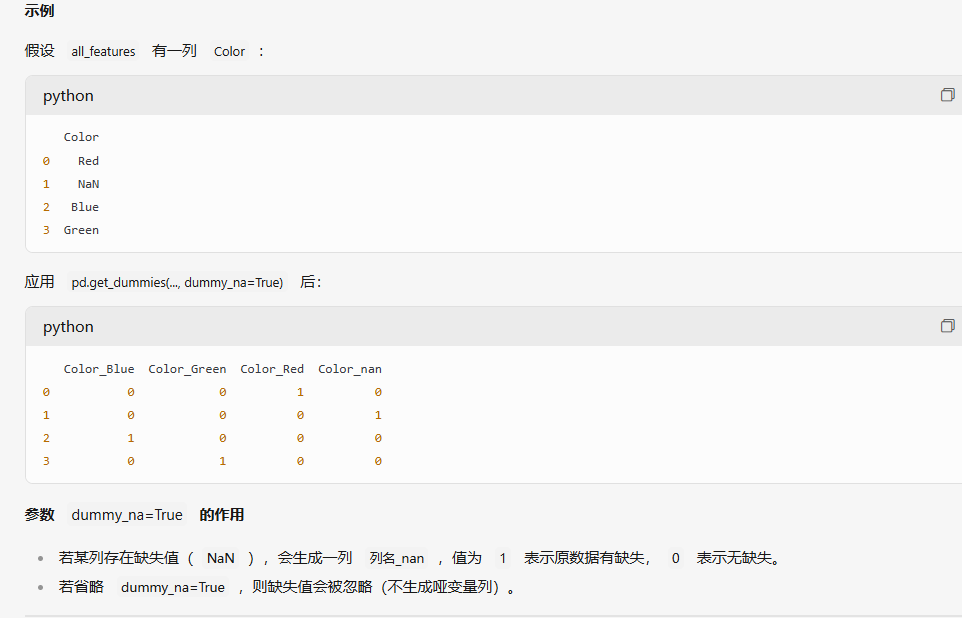

In [36]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 330)

特征（Features）​：是模型的输入变量，用于描述每个样本的属性; 
标签（Labels）​：是模型的输出变量，表示每个样本的目标值。
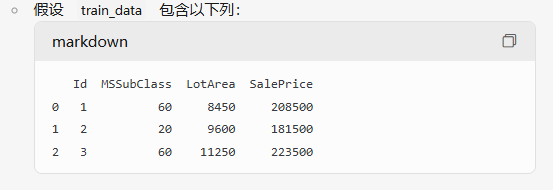
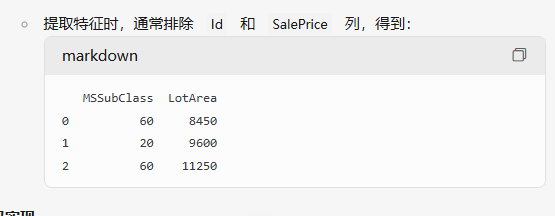
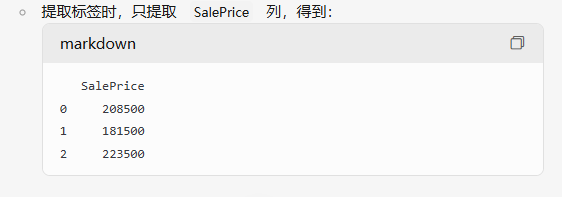

In [38]:
# 将处理后的特征数据和标签转换为 PyTorch 张量，为模型训练和测试做准备
# 从原始训练数据 train_data 中获取样本数量（行数）
n_train = train_data.shape[0]
# all_features[:n_train]：从合并后的特征数据 all_features 中提取前 n_train 行（即训练集特征）
train_features = torch.tensor(all_features[:n_train].values, # .values：将 DataFrame 转换为 NumPy 数组。
                               # torch.tensor(...)：将 NumPy 数组转换为 PyTorch 张量，数据类型为 float32（适合深度学习模型）
                              dtype=torch.float32)
# 对测试集进行类似操作
test_features = torch.tensor(all_features[n_train:].values,
                             dtype=torch.float32)
# train_data.SalePrice.values：从原始训练数据中提取标签列 SalePrice（房价），转换为 NumPy 数组
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), # .reshape(-1, 1)：将一维数组转换为二维列向量
                            #torch.tensor(...)：转换为 float32 类型的张量。
                            dtype=torch.float32)

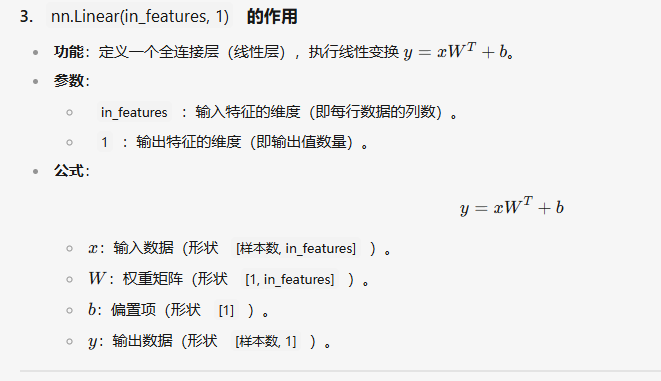

In [ ]:
# 均方误差损失函数
loss = nn.MSELoss()
# 确定输入层的神经元数量: train_features.shape[1] 是特征的数量（即每行数据的列数）
in_features = train_features.shape[1]

# 创建一个简单的单层神经网络（线性回归模型）
def get_net():
    # ​nn.Sequential：将多个网络层按顺序组合成一个模型。
    # ​nn.Linear(in_features, 1)：定义一个全连接层（线性层），将输入特征映射到输出。
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

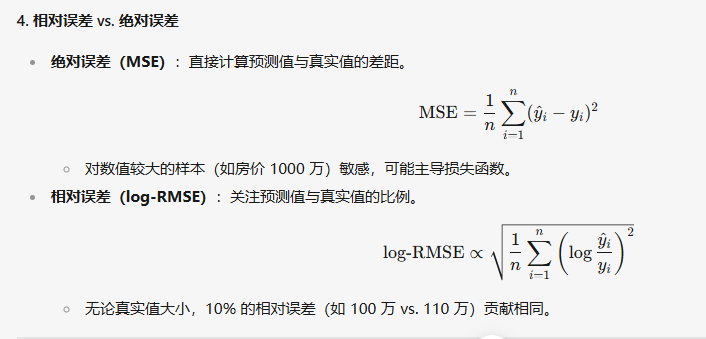

In [ ]:
# 通过对预测值和标签取对数，将优化目标从绝对误差转换为相对误差，使得模型更关注预测值与真实值的比例关系，而非绝对数值差异
# 这种设计在处理量纲差异大的数据时尤为重要，能更公平地优化所有样本
def log_rmse(net, features, labels):
    # 将预测值限制在 [1,+∞) 范围内，确保对数操作有效(房价肯定大于0)
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    # rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

DataLoader 是什么: 将数据集封装为可迭代对象，支持按批次加载数据。
​特点：
​批处理：将数据分成固定大小的批次（batch_size）。
​随机打乱：支持随机打乱数据顺序（shuffle=True）。
​并行加载：支持多线程加载数据（num_workers），提高数据加载效率。

Adam（Adaptive Moment Estimation）是深度学习中广泛使用的一种优化算法，它结合了 ​动量（Momentum）​ 和 ​自适应学习率 的思想，能够高效地调整模型参数;
​特点：
​自适应学习率：为每个参数分配不同的学习率。
​动量机制：跟踪梯度的一阶矩（均值）和二阶矩（方差），避免梯度震荡

In [ ]:
# 训练函数
# net：待训练的神经网络模型。train_features/train_labels：训练集特征和标签。
# test_features/test_labels：测试集特征和标签（可选，用于监控泛化性能）。
# num_epochs：训练轮次。learning_rate：学习率。
# weight_decay：权重衰减（L2正则化系数），用于防止过拟合。batch_size：批处理大小。
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    # 初始化训练与测试损失列表: 记录每轮训练后的训练集和测试集损失
    # 用于监控模型在训练和验证数据上的表现，判断是否过拟合或欠拟合
    train_ls, test_ls = [], []
    # 将训练数据转换为 DataLoader，每次迭代返回一个批次的 (X, y)，大小为 batch_size
    train_iter = d2l.load_array((train_features, train_labels), batch_size) #传入特征和标签, 将数据封装为 TensorDataset 和 DataLoader
    # 定义优化器（Adam）, 并输入待优化的模型参数、学习率、梯度衰减系数
    # 目的：调整模型参数，优化模型
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    # 训练循环
    for epoch in range(num_epochs):
        for X, y in train_iter:
            #梯度清零：optimizer.zero_grad() 清除上一轮的梯度，避免累积
            optimizer.zero_grad()
            # ​前向传播：net(X) 计算模型预测值
            # ​损失计算：loss(net(X), y) 计算预测值与标签的损失
            l = loss(net(X), y)
            # ​反向传播：l.backward() 计算梯度
            l.backward()
            # ​参数更新：optimizer.step() 根据梯度更新模型参数(利用上文的Adam)
            optimizer.step()
        # 训练损失记录：使用 log_rmse 计算当前模型在训练集上的对数均方根误差
        train_ls.append(log_rmse(net, train_features, train_labels))
        # ​测试损失记录：如果提供测试集，计算模型在测试集上的误差
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

正向传播是数据从输入层到输出层的单向流动过程，通过逐层计算生成预测结果。具体步骤包括：
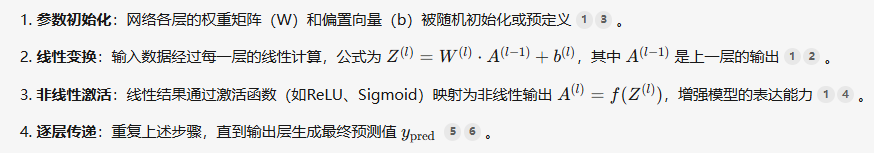

反向传播是误差从输出层向输入层反向传递的过程，用于计算梯度并更新参数。核心步骤包括：
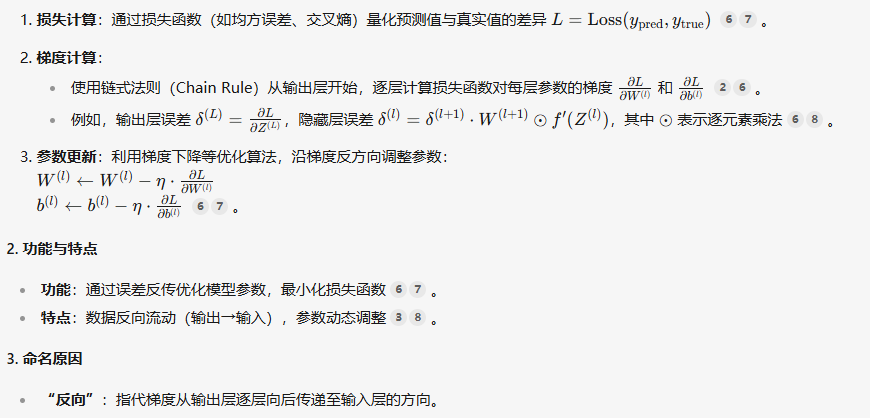

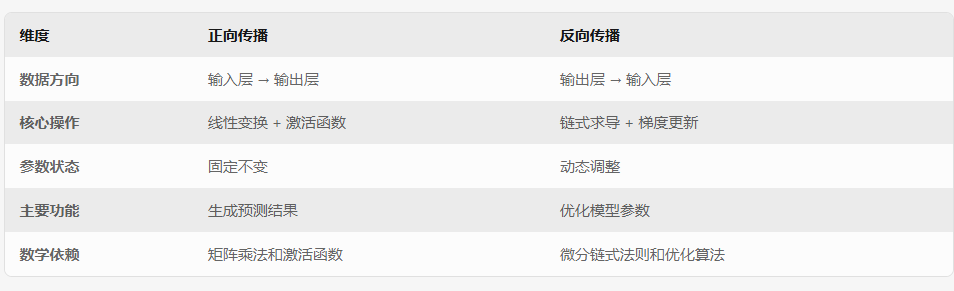

​正向传播：实现模型的推理功能，通过现有参数生成预测结果。
​反向传播：实现模型的学习功能，通过误差反传调整参数以提高预测精度

正向传播和反向传播是深度学习中相辅相成的两个过程：
​正向传播负责生成预测结果，是模型推理的基础；
​反向传播负责优化参数，是模型学习的核心。
两者的方向性和功能差异共同支撑了神经网络的训练与预测能力。

In [ ]:
# k折交叉验证
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [ ]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

In [ ]:
# 模型选择: 设定超参数
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [ ]:
# 训练并生成结果文件(用于提交结果)
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)